In [8]:
# !sudo apt-get install python3.7
# !sudo apt-get update -y
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --config python3

In [19]:
"""
maximum availible volume to pool into
"""
max_volume=500

"""
maximum availible volume to be taken out of well
"""
max_oligo_volume=80

"""
maximum availible volume to be taken out of well
"""
min_oligo_volume=4

# """
# target moles of oligo pmol
# """
# target_quantity=90

In [9]:
!pip install numpy
!pip install pyopenms
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.9 MB/s eta 0:00:00a 0:00:01


In [20]:
import re

EXPERIMENT_NAME = "N4-1A"
# reading file
file1 = open(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}.txt', 'r')
oligo_list = [line for line in file1.readlines() if re.search("^[a-zA-Z][1-9]", line)]
import csv

header = ['where\tcode\tseq\tDMT\tcomment\tlength\t']
data = [row.strip() for row in oligo_list]


with open(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_oligos.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)

    writer = csv.writer(f, quotechar='\"', delimiter='\n', quoting=csv.QUOTE_NONE, escapechar='\\')
    # write the data
    writer.writerow(data)

In [21]:
import pandas as pd

df = pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_oligos.csv', delimiter='\t')
# drop NaN seq
df = df[df['seq'].notna()]
oligo_list = df['seq'].to_list()

In [22]:
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight

# Bio.SeqUtils.molecular_weight(seq, seq_type='DNA', double_stranded=False, circular=False, monoisotopic=False)

from pyopenms import *

mass_list=[]
# https://biopython.org/docs/1.75/api/Bio.SeqUtils.html
for oligo_seq in oligo_list: 
    try:
        my_dna = Seq(oligo_seq)
    except:
        print(oligo_seq)
    try:
        print(f"{oligo_seq.strip()}\t" + "%0.2f" % (molecular_weight(my_dna)-79.97))
        mass_list+=["%0.2f" % (molecular_weight(my_dna)-79.97)]
    except ValueError:
        print(f"{oligo_seq.strip()}\t" + "'N' is not a valid unambiguous letter for DNA")
        mass_list+=["NaN"]
    
df['monoisotopic_mass']=mass_list
export_dataframe=df[['where', 'code', 'length', 'seq', 'monoisotopic_mass']]
export_dataframe.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_calculated.csv', sep = '\t', index=False)


ATC TGT ATC TTA AAG ACT ATC ATC AAG ACT CAC ATC AAG ACT ATC ATC AAG TCA TAC	17390.25
TAT ATC TTG ATG ATT ACC TAA AGA GGA GAT GAT TGA TGT ATG ACT TGA TGA TAG TCT TGA TG	19269.41
TCC TCT TTA GGT AAT CAT CAA GAT ATA CGG TAA GAC TAT CAT CAA GAC TAA CAT CAA GTC AAG ACC	20240.07
GCT TAT TGA TTG GCT TAT GGT CTA TCC TTT AGA TAG GTC TTG ACT TGA TGT TAG TCT	17572.26
GAC CAT AAG CCA ATC AAT AAG CCC ACA CTA TAA GGA GGA GAC AAA CAG AGA	15738.21
GAC TAT CTC TTA TAG TTC TCC TCT TAT AGT CTC TGT TTG TCT CCT CCT T	14812.50
ATA AGA GGA GAA CTA TAA GAG ATA GTC ACT AAC AAA CAA TTA TAA TAA GAA TAA T	17064.11
AAG ATA GTC TTT AAG TCT ATG ATT GTA ATA GTA TTA TTC TTA TTA TAA TTG TTT GTT AGT	18531.96
ATT ACA ATC ATA GAC TTA AAG ACT ATC TTA AAG ATT ATC TCA AAA TAC CTA TTG ACT AT	18060.71
CCG TCT CGA TGG AAT GAA TAA TAC ATA GAC CAG ACA CCA TAG TCA ATA GGT ATT TTG AGA TAA TCT	20351.13
TTA TTC ATT CCA TCG AGA CGG GAC ATA GAG ACC TTA CCC GAA AGG AAG T	15097.74
TGC TAC TTA ACG TTA TCA GAC TTA GTG ACT TCC TTT CGG GTA A

In [23]:
# reading file
df_calculated =  pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_calculated.csv', delimiter='\t', decimal=".")

# read concentrations
df = pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_concentrations.csv', delimiter='\t', decimal=".")

"""
strip the text everywhere on data frame
"""
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())
"""
and again
"""
cols = df_calculated.select_dtypes(object).columns
df_calculated[cols] = df_calculated[cols].apply(lambda x: x.str.strip())

"""
now merge cleaned dataframes
"""
merge = pd.merge(df, df_calculated, on='where', how='inner', suffixes=('', '_drop'))
#Drop the duplicate columns
merge.drop([col for col in merge.columns if 'drop' in col], axis=1, inplace=True)

# reassign
df = merge

In [24]:
import sys
from Bio.Seq import Seq

# calculation of oligo extinction coefficients (mM^–1*cm^–1);
def e260_func(sequence):
    Coefficients = {
        "a": 15.4,
        "c": 7.4,
        "g": 11.5,
        "t": 8.7,
        "aa": 13.7,
        "ac": 10.6,
        "ag": 12.5,
        "at": 11.4,
        "ca": 10.6,
        "cc": 7.3,
        "cg": 9,
        "ct": 7.6,
        "ga": 12.6,
        "gc": 8.8,
        "gg": 10.8,
        "gt": 10,
        "ta": 11.7,
        "tc": 8.1,
        "tg": 9.5,
        "tt": 8.4,
    }
    
    Coefficients =  {key.upper(): val for key, val in Coefficients.items()}
    e260 = 0
    sequence = Seq(sequence.replace(" ", ""))
    
    for i in range(0, len(sequence) - 1):
        e260 = e260 + 2 * Coefficients[sequence[i] + sequence[i + 1]]
    for i in range(0, len(sequence) - 2):
        e260 = e260 - Coefficients[sequence[i + 1]]
    return e260

# CHANGE THIS LATER
Yield = 100

df["e260_mM^-1cm^-1"] = df["seq"].map(e260_func)
df["corrected_molar_concentration_pmol/mkl"] = (1000*2*df["A260"] / (df["e260_mM^-1cm^-1"] * (1 + (100/ Yield)))) ## (mmol/L == nmol/mkl)
df["corrected_weght_concentration"]=df["corrected_molar_concentration_pmol/mkl"]*df["monoisotopic_mass"]/1000 ## ng/mkl
df["corrected_Nucleic_Acid_Factor"]=(2/(df["e260_mM^-1cm^-1"] * (1 + (100/ Yield))))*df["monoisotopic_mass"]

df = df.round(2)

# write final merged result
df.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_merged_input.csv', encoding='UTF8')

In [25]:
for i in df.columns:
    try:
        df[i] = df[i].str.replace(',', '.').astype(float)
    except:
        pass
    
df['monoisotopic_mass'] = df['monoisotopic_mass'].astype(float)
df["pM/mkl"] = 1000*df['Nucleic Acid(ng/uL)']/df['monoisotopic_mass']
# df=df.dropna()

"""
ATTENTION!!! HERE YOU CAN CHANGE POOL NAME!!!
"""

pool_1 = "VibriophageN4_F3-"

POOL_NAME=pool_1

df = df[df["code"].str.contains(f'^{POOL_NAME}\d+')]
# df = df.loc[52:68]

df

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),Baseline Absorbance,code,length,seq,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl
0,A7,06.12.2023 9:57,Sample 1,400.46,2.01,1.52,12.14,6.03,33.0,340,0.03,VibriophageN4_F3-1,#= 50,CTG ATA AAC CAC AAG ATA TCT ATG GTA TCG TTG CT...,15496.00,505.7,24.00,371.85,30.64,25.842798
1,B7,06.12.2023 9:57,Sample 2,415.57,1.82,1.10,12.59,6.94,33.0,340,0.02,VibriophageN4_F3-2,#= 58,CGT CTT CTG TAC CGC TAA TCA CAA GGT CAC GTA GT...,17631.34,542.0,23.23,409.65,32.53,23.569961
2,C7,06.12.2023 9:58,Sample 3,382.94,2.13,1.13,11.60,5.45,33.0,340,0.04,VibriophageN4_F3-3,#= 44,GAT TAG CGG TAC AGA AGA CGA GAT GCA AAC TCT CG...,13664.85,459.1,25.28,345.39,29.76,28.023725
3,D7,06.12.2023 9:59,Sample 4,318.82,1.70,1.47,9.66,5.67,33.0,340,0.00,VibriophageN4_F3-4,#= 45,AGA CGT TCA GTG ATT TCA CCA GTC TTC TTG TCT TC...,13798.86,419.7,23.02,317.63,32.88,23.104807
4,E7,06.12.2023 9:59,Sample 5,386.47,1.74,1.50,11.71,6.72,33.0,340,0.03,VibriophageN4_F3-5,#= 58,GGT GAA ATC ACT GAA CGT CTT GTG CTT GGT ACT CG...,17885.45,540.4,21.67,387.60,33.10,21.608067
5,F7,06.12.2023 10:00,Sample 6,257.70,1.93,1.31,7.81,4.05,33.0,340,0.00,VibriophageN4_F3-6,#= 45,AGT TAC TGA GCG AGT CAC ACC ATA TTC TAA CCA TT...,13797.90,441.4,17.69,244.10,31.26,18.676755
6,G7,06.12.2023 10:01,Sample 7,413.15,1.82,1.41,12.52,6.86,33.0,340,-0.00,VibriophageN4_F3-7,#= 54,TGT GAC TCG CTC AGT AAC TAA ACG CTC AGT TAT GA...,16561.64,509.1,24.59,407.29,32.53,24.946201
7,H7,06.12.2023 10:02,Sample 8,424.99,1.96,1.25,12.88,6.55,33.0,340,0.00,VibriophageN4_F3-8,#= 49,CAA ACA CTT GGT CAG CAA AGC CAT ACT CTT TAG AG...,15026.70,481.0,26.78,402.35,31.24,28.282324
8,I7,06.12.2023 10:02,Sample 9,469.35,1.91,1.41,14.22,7.44,33.0,340,0.48,VibriophageN4_F3-9,#= 54,CTT TGC TGA CCA AGT GTT TGA AGA TAC TGT GAT GC...,16659.72,522.8,27.21,453.23,31.87,28.172742
9,J7,06.12.2023 10:03,Sample 10,305.86,1.75,1.37,9.27,5.29,33.0,340,-0.03,VibriophageN4_F3-10,#= 38,CTC AGT GAA CAT TGC ACC TTT GCC ATT GTC GAT AG...,11619.48,352.3,26.31,305.71,32.98,26.323037


Text(0, 0.5, 'occurencies')

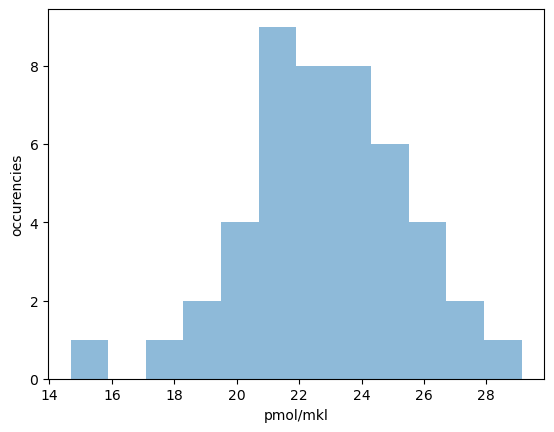

In [26]:
"""
смотрим распределение по корзинам
"""
ax = df['corrected_molar_concentration_pmol/mkl'].plot.hist(bins=12, alpha=0.5)
initial_oligos_concentrations = df['corrected_molar_concentration_pmol/mkl']
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

In [27]:
'''
определяем выбросы
'''
import pandas
import numpy as np
from scipy import stats

# %reload_ext google.colab.data_table

df['score'] = np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl']))<1.8
# df[(np.abs(stats.zscore(df)) < 1.5).all(axis=1)]
filtered, filtered_off = (df[(np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl'])) < 1.8)], df[(np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl'])) >= 1.8)])
filtered_off

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),...,code,length,seq,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl,score
5,F7,06.12.2023 10:00,Sample 6,257.7,1.93,1.31,7.81,4.05,33.0,340,...,VibriophageN4_F3-6,#= 45,AGT TAC TGA GCG AGT CAC ACC ATA TTC TAA CCA TT...,13797.90,441.4,17.69,244.10,31.26,18.676755,False
35,D9,06.12.2023 10:25,Sample 36,286.5,2.02,1.09,8.68,4.29,33.0,340,...,VibriophageN4_F3-36,#= 58,GTG TGG GTT AAT TCA GGA GGG AGG CGC TCA GAT AT...,18098.64,591.6,14.68,265.61,30.59,15.829919,False
42,K9,06.12.2023 10:29,Sample 43,387.2,1.87,1.27,11.73,6.29,33.0,340,...,VibriophageN4_F3-43,#= 42,CTT AGT GAT TAC ACC GAC CGC TGA TAT CCA AGG TA...,12842.28,402.8,29.13,374.08,31.88,30.150409,False


Text(0, 0.5, 'occurencies')

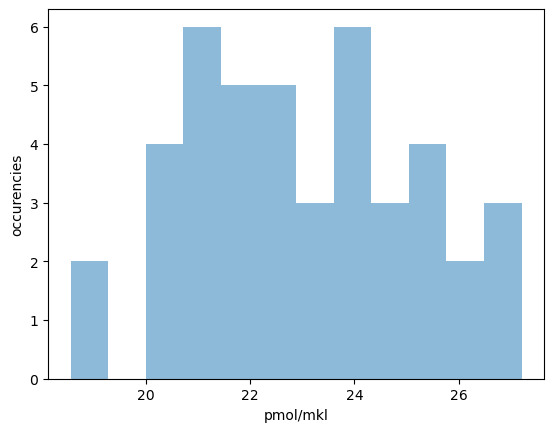

In [28]:
"""
смотрим распределение по корзинам
"""
ax = filtered['corrected_molar_concentration_pmol/mkl'].plot.hist(bins=12, alpha=0.5)
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

In [29]:
"""
split into N bins by quantiles
"""
N = 8

labels=list(np.arange(1, N))
labels = [str(elem) for elem in labels]
q = list(np.linspace(0, 1, N))

filtered["quantile"] = pd.qcut(df['corrected_molar_concentration_pmol/mkl'], q=q, labels=labels)

'''
выравниваем группы концентраций в пределах отличия в 1.5 раз
'''
highest_quantile_median_conc = filtered[filtered['quantile'] == labels[-1]]['corrected_molar_concentration_pmol/mkl'].median()
for i in labels:
    
    i_quantile_median_conc = filtered[filtered['quantile'] == i]['corrected_molar_concentration_pmol/mkl'].median()
    mkl = round(5*highest_quantile_median_conc/i_quantile_median_conc)
    filtered.loc[filtered['quantile'] == i, ['mkl']] = mkl


"""
пересчитываем моли
"""
filtered['pmol'] = filtered['mkl']*filtered['corrected_molar_concentration_pmol/mkl']
median_conc = round(filtered['corrected_molar_concentration_pmol/mkl'].median())
median_moles_in_pool = round(filtered['pmol'].median())
# print(filtered.sort_values('pM/mkl'))
print(f"equalized result: median_moles_in_pool = {median_moles_in_pool}")
filtered

equalized result: median_moles_in_pool = 132


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),...,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl,score,quantile,mkl,pmol
0,A7,06.12.2023 9:57,Sample 1,400.46,2.01,1.52,12.14,6.03,33.0,340,...,15496.00,505.7,24.00,371.85,30.64,25.842798,True,5,6.0,144.00
1,B7,06.12.2023 9:57,Sample 2,415.57,1.82,1.10,12.59,6.94,33.0,340,...,17631.34,542.0,23.23,409.65,32.53,23.569961,True,4,6.0,139.38
2,C7,06.12.2023 9:58,Sample 3,382.94,2.13,1.13,11.60,5.45,33.0,340,...,13664.85,459.1,25.28,345.39,29.76,28.023725,True,6,5.0,126.40
3,D7,06.12.2023 9:59,Sample 4,318.82,1.70,1.47,9.66,5.67,33.0,340,...,13798.86,419.7,23.02,317.63,32.88,23.104807,True,4,6.0,138.12
4,E7,06.12.2023 9:59,Sample 5,386.47,1.74,1.50,11.71,6.72,33.0,340,...,17885.45,540.4,21.67,387.60,33.10,21.608067,True,3,6.0,130.02
6,G7,06.12.2023 10:01,Sample 7,413.15,1.82,1.41,12.52,6.86,33.0,340,...,16561.64,509.1,24.59,407.29,32.53,24.946201,True,6,5.0,122.95
7,H7,06.12.2023 10:02,Sample 8,424.99,1.96,1.25,12.88,6.55,33.0,340,...,15026.70,481.0,26.78,402.35,31.24,28.282324,True,7,5.0,133.90
8,I7,06.12.2023 10:02,Sample 9,469.35,1.91,1.41,14.22,7.44,33.0,340,...,16659.72,522.8,27.21,453.23,31.87,28.172742,True,7,5.0,136.05
9,J7,06.12.2023 10:03,Sample 10,305.86,1.75,1.37,9.27,5.29,33.0,340,...,11619.48,352.3,26.31,305.71,32.98,26.323037,True,7,5.0,131.55
10,K7,06.12.2023 10:04,Sample 11,410.98,1.80,1.42,12.45,6.92,33.0,340,...,17195.04,525.9,23.68,407.20,32.70,23.901078,True,5,6.0,142.08


In [30]:
filtered_off['mkl'] = median_moles_in_pool/filtered_off['corrected_molar_concentration_pmol/mkl']
filtered_off.loc[filtered_off['mkl'] >= max_oligo_volume, ['mkl']] = max_oligo_volume
filtered_off.loc[filtered_off['mkl'] <= min_oligo_volume, ['mkl']] = min_oligo_volume
filtered_off['mkl'] = round(filtered_off['mkl'])
filtered_off

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),...,length,seq,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl,score,mkl
5,F7,06.12.2023 10:00,Sample 6,257.7,1.93,1.31,7.81,4.05,33.0,340,...,#= 45,AGT TAC TGA GCG AGT CAC ACC ATA TTC TAA CCA TT...,13797.90,441.4,17.69,244.10,31.26,18.676755,False,7.0
35,D9,06.12.2023 10:25,Sample 36,286.5,2.02,1.09,8.68,4.29,33.0,340,...,#= 58,GTG TGG GTT AAT TCA GGA GGG AGG CGC TCA GAT AT...,18098.64,591.6,14.68,265.61,30.59,15.829919,False,9.0
42,K9,06.12.2023 10:29,Sample 43,387.2,1.87,1.27,11.73,6.29,33.0,340,...,#= 42,CTT AGT GAT TAC ACC GAC CGC TGA TAT CCA AGG TA...,12842.28,402.8,29.13,374.08,31.88,30.150409,False,5.0


In [31]:
"""
FINAL CONCATENATION AND VOLUME ASSERTION TEST
"""
result = pd.concat([filtered_off, filtered])
result['pmol'] = result['mkl']*result['corrected_molar_concentration_pmol/mkl']
total = result['mkl'].sum()
result['final conc, pmol/mkl'] = round(result['pmol']/total, 2)
print(f"calculated total volume of pool: {total} mkl")
# assert total < total_volume, "max volume exceeded"

'''
если пул больше max_volume (500 мкл) - разбиваем на столько пробирок, сколько потребуется
'''
pool_index_list = []
sum = 0
for i in result['mkl']:
  sum+=i
  pool_index_list+=[round(1+sum//max_volume)]

result['target_well'] = pool_index_list

'''
проверяем, что у нас нет разницы концентраций на порядок
'''
assert min(result['final conc, pmol/mkl'])*10 > max(result['final conc, pmol/mkl']), "разброс концентраций превышает 1 порядок!!!\nЭто непорядок!!!"
"""
если все хорошо - идем дальше
"""
result.sort_index(inplace=True)
result
print(f"разбито на {max(pool_index_list)} пробирки(ок)")

calculated total volume of pool: 272.0 mkl
разбито на 1 пробирки(ок)


In [32]:
"""
FINALWORKLIST EXPORT
"""
volume_list = round(result['mkl'], 0).astype(int)
number_of_wells = len(volume_list)

def coordinate_to_number_parser(list_of_coords):
    '''
    переводит координату на плашке из формата A1 в порядковый номер
    '''
    index_list = []
    for i in list_of_coords: 
        
        row = ord(i[0]) - 64
        column = int(i[1:])
        index_list += [16*(column-1)+row]
    
    return index_list

list_of_indexes = coordinate_to_number_parser(result["where"].to_list())

col1 = ["384well"]*number_of_wells
col2 = list_of_indexes
col3 = ["96well"]*number_of_wells
col4 = pool_index_list
col5 = volume_list.to_list()

list_of_lists = [col1, col2, col3, col4, col5]

worklist_df = pd.DataFrame(list_of_lists)
worklist_df = worklist_df.reset_index(drop=True)
worklist_df = worklist_df.T

"""
экспортируем новый worklist
"""
worklist_df.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_equalized_conc_worklist_{POOL_NAME}.csv', encoding='UTF8', header=None, index=False)


"""
SOME METADATA
"""
final_equalized_oligo_concentration=median_moles_in_pool/worklist_df[4].sum()
total_volume=worklist_df[4].sum()


print(f"final_equalized_oligo_concentration = ~{final_equalized_oligo_concentration:.3f} pmol/mkl")
print(f"total_volume = {total_volume:.1f} mkl")
print(f"minimal taken volume = {min(worklist_df[4]):.2f} mkl")
print(f"max taken volume = {max(worklist_df[4]):.2f} mkl")
print(f"max разброс финальных концентраций = {100*(max(result['final conc, pmol/mkl'])-min(result['final conc, pmol/mkl']))/(result['final conc, pmol/mkl'].mean()):.2f}% или в {2*(max(result['final conc, pmol/mkl'])-min(result['final conc, pmol/mkl']))/(result['final conc, pmol/mkl'].mean()):.2f} раз")
print(f"среднее значение концентраций {result['final conc, pmol/mkl'].mean():.3f}±{result['final conc, pmol/mkl'].std():.3f} pmol/mkl")

result.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_result.csv', encoding='UTF8')

final_equalized_oligo_concentration = ~0.485 pmol/mkl
total_volume = 272.0 mkl
minimal taken volume = 5.00 mkl
max taken volume = 9.00 mkl
max разброс финальных концентраций = 18.35% или в 0.37 раз
среднее значение концентраций 0.490±0.025 pmol/mkl


Text(0, 0.5, 'occurencies')

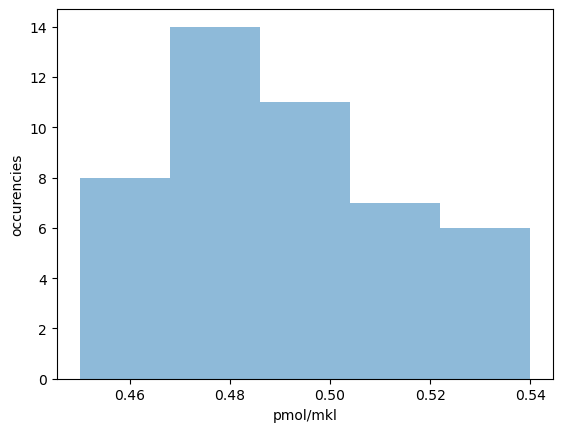

In [33]:
"""
смотрим распределение по корзинам
"""
ax = result['final conc, pmol/mkl'].plot.hist(bins=5, alpha=0.5)
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

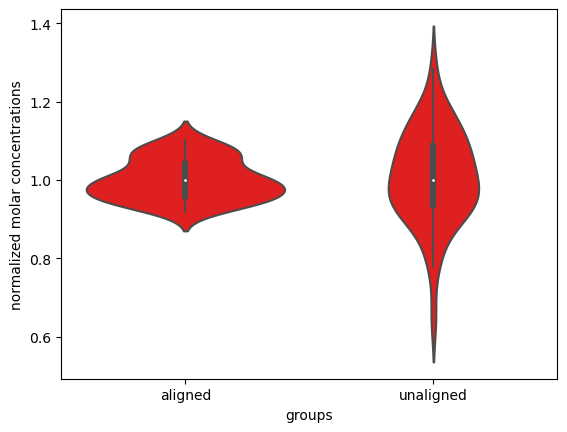

In [34]:
comparison_df = pd.DataFrame([initial_oligos_concentrations, result['final conc, pmol/mkl']]).T
comparison_df["unaligned"] = comparison_df["corrected_molar_concentration_pmol/mkl"]/comparison_df["corrected_molar_concentration_pmol/mkl"].median()
comparison_df["aligned"] = comparison_df['final conc, pmol/mkl']/comparison_df['final conc, pmol/mkl'].median()
comparison_df = comparison_df[["aligned", "unaligned"]]
comparison_df = comparison_df.melt(var_name='groups', value_name='normalized molar concentrations')

import seaborn as sns

ax = sns.violinplot(x = "groups", y="normalized molar concentrations", data=comparison_df, color='r', alpha = 0.1)


# final concentration dependency on yield:
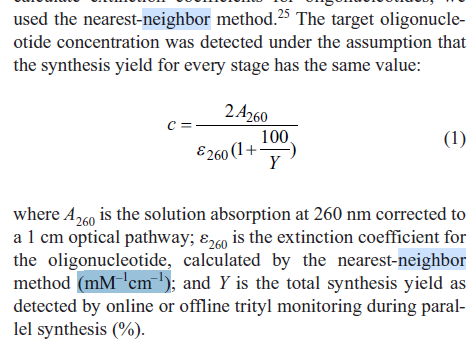
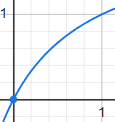

In [ ]:
Сравниваем 4 эксперимента 
 - с выравниванием и без + эти два с очисткой на магнитных частицах
 - Как сравнивать? 
     - смотреть распределение продуктов на капиллярном форезе
     - по интенсивности на форезе при одинаковом количестве циклов 
     - на риалтаймнике
 - Можно ли одновременно на риалтаймнике?
